# Library 

In [ ]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
from sklearn.cluster import KMeans

# Preprocessing

In [2]:
data = pd.read_csv("data.csv")
df1 = data
pattern = r"\$\d+(,\d{3})*(\.\d+)??"
def clean_price(price_str):
  match = re.search(pattern, price_str)
  if match:
      cleaned_price = match.group().strip("$").replace(",", "")
      return float(cleaned_price)
  else:
      return None
df1["Price"] = df1["Price"].apply(clean_price)

df2 = df1
pattern = r"(\d+)\s*(?:day|days)\s*(?:on\s*site|site)?"

def clean_days(days_str):
  match = re.search(pattern, days_str, flags=re.IGNORECASE)
  if match:
    return int(match.group(1))
  else:
    return None
df2["No_of_days_onsite"] = df2["No_of_days_onsite"].apply(clean_days)

df3 = df2
def split_location(location_str):
  pattern = r"(.*?)\, (.*?)\, (.*)"
  match = re.match(pattern, location_str)
  if match:
    return match.groups()
  else:
    return [None, None, None]

df3[['Address', 'City', 'Zipcode']] = df3['Location'].apply(split_location).tolist()
df3 = df3.drop('Location', axis=1)
df4 = df3
df_f = df4[df4['Beds'] != '–']

df_f = df_f[(df_f['Year_built'] != '0') & (~df_f['Year_built'].isna())]
df_f['Year_built'] = df_f['Year_built'].replace('–', pd.NA)
df_f.dropna(subset=['Year_built'], inplace=True)

df_f = df_f[df_f['Baths'] != '–']
df_f['Baths'] = pd.to_numeric(df_f['Baths'], errors='coerce')
df_f.dropna(subset=['Baths'], inplace=True)
df_final = df_f

In [3]:
df_final['Beds'] = df_final['Beds'].astype("int64")
df_final['Baths'] = df_final['Baths'].astype("int64")
df_final['No_of_days_onsite'] = df_final['No_of_days_onsite'].astype("int64")

df_final['Sqft'] = df_final['Sqft'].str.replace(',', '')
df_final['Sqft'] = df_final['Sqft'].astype("int64")

df_final.loc[df_final['Sqft'] == 0, 'Sqft'] = np.nan
df_final.dropna(subset=['Sqft'], inplace=True)

In [4]:
df_final['Year_built'] = df_final['Year_built'].astype("int64")
df_final['Property_type'] = df_final['Property_type'].astype("str")
df_final['Address'] = df_final['Address'].astype("str")
df_final['City'] = df_final['City'].astype("str")

In [5]:
def extract_numbers(text):
    zip_pattern = r'\b\d{5}\b'
    match = re.search(zip_pattern, text)
    if match:
        return match.group(0)
    else:
        return None

df_final['Zipcode'] = df_final['Zipcode'].apply(extract_numbers)
df_final['Zipcode'] = df_final['Zipcode'].str.join('')
df_final.dropna(subset=['Zipcode'], inplace=True)
df_final['City'] = df_final['City'].str.strip()

df_final

,MLS_id,Price,Beds,Baths,Sqft,Year_built,Property_type,HOA,No_of_days_onsite,Address,City,Zipcode
0,ML81964272,2998888.0,4,3,2764.0,1986,Single Family Residence,420,1,46097 Raindance Rd,Fremont,94539
1,ML81964119,580000.0,2,2,1125.0,1986,Condominium,703,1,3454 Bridgewood Ter #111,Fremont,94536
2,BE41057198,1588000.0,4,2,1797.0,1965,Single Family Residence,703,1,36163 Corsica,Fremont,94536
3,BE41058557,699888.0,2,2,1040.0,1991,Condominium,418,1,3695 Stevenson Blvd #211,Fremont,94538
4,ML81964175,799000.0,2,2,930.0,1987,Townhouse,475,1,4875 Richland Ter,Fremont,94555
...,...,...,...,...,...,...,...,...,...,...,...,...
801,BE41049475,685000.0,2,2,947.0,2000,Condominium,365,87,51 Bellington Cmn #8,Livermore,94551
802,CC41049309,4195000.0,5,6,5992.0,1975,Single Family Residence,365,89,12400 Morgan Territory Rd,Livermore,94551
803,CC41049163,375000.0,1,1,758.0,1974,Condominium,523,93,1087 Murrieta Blvd #337,Livermore,94550
804,BE41043078,7200000.0,3,2,2424.0,1930,Single Family Residence,523,191,8100 Carneal Rd,Livermore,94551


# Create dummies

In [6]:
df_final = pd.get_dummies(df_final, columns=['Property_type','City'], drop_first=True)

In [7]:
df_final.columns

Index(['MLS_id', 'Price', 'Beds', 'Baths', 'Sqft', 'Year_built', 'HOA',
       'No_of_days_onsite', 'Address', 'Zipcode',
       'Property_type_Manufactured Home', 'Property_type_Manufactured In Park',
       'Property_type_Residential', 'Property_type_Single Family Residence',
       'Property_type_Townhouse', 'City_Berkeley', 'City_Dublin',
       'City_Fremont', 'City_Hayward', 'City_Livermore', 'City_Newark',
       'City_Oakland', 'City_Piedmont', 'City_Pleasanton', 'City_Sunol',
       'City_Union City'],
      dtype='object')

# transformation

In [8]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# Assuming df_final is your DataFrame
numeric_fields = ['Price', 'Beds', 'Baths', 'Sqft', 'Year_built', 'HOA', 'No_of_days_onsite']

# Apply log transformation to numeric fields
df_cluster = df_final.copy()
for field in numeric_fields:
    df_cluster[field] = np.log(df_cluster[field] + 1)  # Adding 1 to handle zero values

df_cluster.set_index('MLS_id', inplace=True)
df_cluster = df_cluster.drop(columns=['Address','Zipcode'])

# Min-Max Scaling (Normalization)
min_max_scaler = MinMaxScaler()
df_cluster_scaled = min_max_scaler.fit_transform(df_cluster)

# Convert scaled array back to DataFrame
df_cluster_scaled = pd.DataFrame(df_cluster_scaled, columns=df_cluster.columns, index=df_cluster.index)

# Visualize the transformed DataFrame
print(df_cluster_scaled.head())

               Price      Beds     Baths      Sqft  Year_built       HOA  \
MLS_id                                                                     
ML81964272  0.611888  0.698970  0.386853  0.559233    0.733605  0.836127   
ML81964119  0.207260  0.477121  0.226294  0.289273    0.733605  0.907269   
BE41057198  0.455312  0.698970  0.226294  0.429908    0.584193  0.907269   
BE41058557  0.253533  0.477121  0.226294  0.265687    0.768947  0.835468   
ML81964175  0.286151  0.477121  0.226294  0.232128    0.740681  0.853116   

            No_of_days_onsite  Property_type_Manufactured Home  \
MLS_id                                                           
ML81964272           0.088364                              0.0   
ML81964119           0.088364                              0.0   
BE41057198           0.088364                              0.0   
BE41058557           0.088364                              0.0   
ML81964175           0.088364                              0.0   

    

In [9]:
df_cluster = df_cluster_scaled

# Optimal cluster

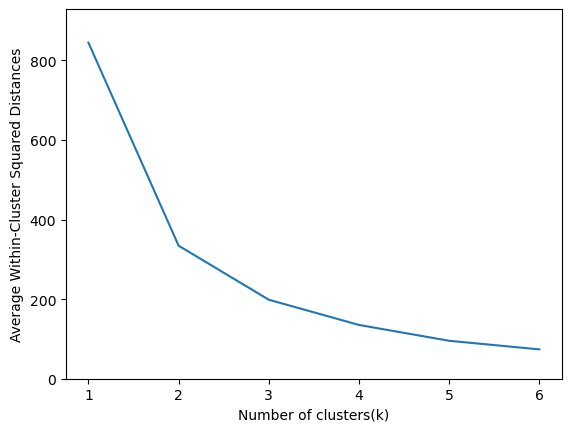

In [10]:
inertia = []
for n_clusters in range(1, 7):
    kmeans = KMeans(n_clusters=n_clusters, random_state=0,n_init=10).fit(df_cluster)
    inertia.append(kmeans.inertia_ / n_clusters)
inertias = pd.DataFrame({'n_clusters': range(1, 7), 'inertia': inertia})
ax = inertias.plot(x='n_clusters', y='inertia')
plt.xlabel('Number of clusters(k)')
plt.ylabel('Average Within-Cluster Squared Distances')
plt.ylim((0, 1.1 * inertias.inertia.max()))
ax.legend().set_visible(False)
plt.show()

# K means model

In [11]:
kmeans = KMeans(n_clusters=4, random_state=0,n_init=10).fit(df_cluster)

memb = pd.Series(kmeans.labels_, index=df_cluster.index)
for key, item in memb.groupby(memb):
    print(key, ': ', ', '.join(item.index))

0 :  BE41056800, BE41058089, ML81963242, ML81962679, BE41056405, CRNDP2403267, BE41056073, ML81961015, BE41054165, ML81958745, BE41051644, ML81963917, BE41057335, BE41057986, ML81963007, BE41056261, BE41054454, BE41056782, ML81962281, BE41056684, BE41056419, ML81958730, CC41056371, BE41054883, CC41054731, BE41054349, ME222108736, EB41058497, BE41058434, EB41058519, EB41058517, BA324033388, EB41058415, BE41058471, EB41058389, BE41058429, BE41058359, EB41058381, EB41058318, EB41058365, ML81963379, EB41058174, EB41058122, EB41058051, SF424024241, BE41058030, BE41057996, BE41057184, ML81963236, BE41056088, BE41056557, BE41055836, ML81960286, BE41055024, BE41053853, ML81959125, BE41051938, ML81957809, BE41053297, ML81957644, BE41052592, ML81957099, BE41052156, BE41052111, ML81945375, BA323909913, ML81939629, CC41058370, BE41058273, CC41058187, BE41058154, EB41057618, BE41057551, ML81963108, BE41057196, BE41056970, BE41056718, BE41056547, BA324028180, EB41056181, EB41056375, BE41056353, BE41

# Centroids

In [12]:
centroids = pd.DataFrame(kmeans.cluster_centers_, columns=df_cluster.columns)
pd.set_option('display.precision', 3)
print(centroids)

   Price   Beds  Baths   Sqft  Year_built    HOA  No_of_days_onsite  \
0  0.247  0.483  0.213  0.289       0.763  0.843              0.330   
1  0.408  0.640  0.299  0.440       0.505  0.649              0.279   
2  0.377  0.581  0.273  0.357       0.703  0.819              0.254   
3  0.463  0.635  0.360  0.460       0.705  0.806              0.250   

   Property_type_Manufactured Home  Property_type_Manufactured In Park  \
0                        8.674e-19                           1.342e-02   
1                        3.036e-18                           6.072e-18   
2                        1.205e-02                           5.204e-18   
3                        6.505e-19                           1.301e-18   

   Property_type_Residential  ...  City_Dublin  City_Fremont  City_Hayward  \
0                  6.711e-03  ...    1.074e-01    -2.776e-17     2.416e-01   
1                  3.036e-18  ...    6.164e-02    -1.943e-16     1.575e-01   
2                  2.602e-18  ...    4.

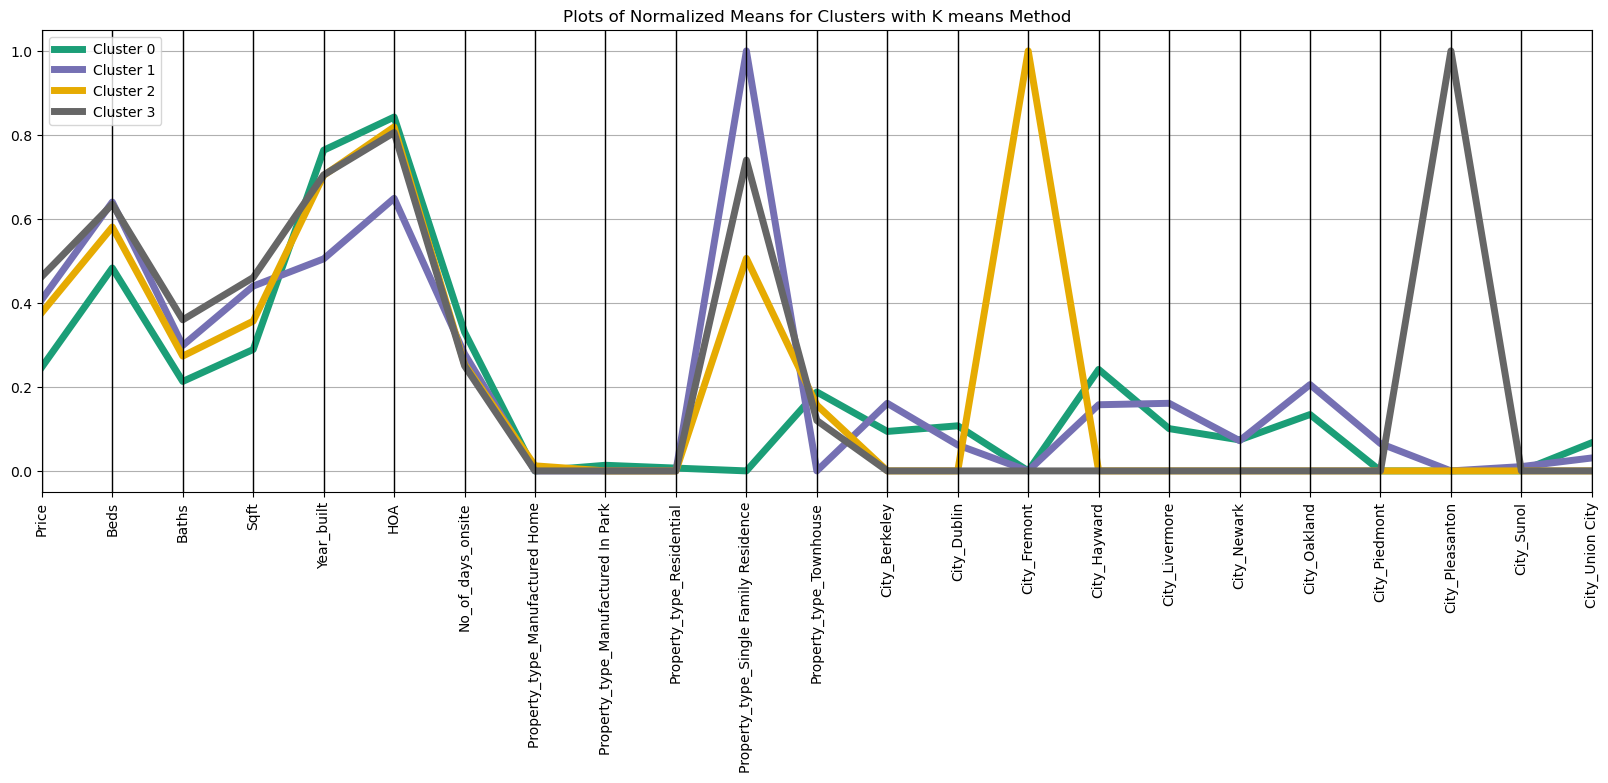

In [13]:
centroids['Cluster'] = ['Cluster {}'.format(i) for i in centroids.index]
pd.set_option('display.precision', 3)

plt.figure(figsize=(20, 6))
ax = parallel_coordinates(centroids, class_column='Cluster', colormap='Dark2', linewidth=5)
plt.xticks(rotation=90)
plt.legend(loc='upper left')
plt.title('Plots of Normalized Means for Clusters with K means Method')
plt.show()